<a href="https://colab.research.google.com/github/hyunku/Brain-Machine_Interface_System/blob/main/simpleESN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 라이브러리 import

In [ ]:
!pip install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.5 MB 8.4 MB/s 


In [ ]:
##필요 모듈 import
import os
import sys
import pandas as pd
import numpy as np
from scipy import signal
import mne
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import pyplot as plt
from datetime import datetime
import time
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
import math
from google.colab import drive
drive.mount('/content/drive')

%matplotlib inline

Mounted at /content/drive


# ESN 과정 간단설명 및 ESN 정의 - spectral radius는 여기서 수정

1. ESN 모델 설정
2. train 셋 ESN 모델 통과시켜서 ESN의 가중치 학습
3. ESN 모델을 통과시킨 train 셋을 학습시킬 머신러닝 모델 학습
4. test 셋을 학습시킨 ESN모델에 통과시킴 (ESN 학습 X)
5. 통과시킨 test 데이터셋을 train셋으로 학습된 머신러닝 모델 통과시킴.
6. ESN + 머신러닝 모델을 통과시킨 결과 예측

<크게 두 단계에 걸쳐서 진행>

ESN 과 ESN 통과시킬 선형모델 생성 후 각각 학습

학습시킨 ESN, 모델 사용

In [ ]:
"""Simple Echo State Network
"""

import numpy as np
from numpy import arange, array, concatenate, ones, tanh, vstack, zeros

import scipy.linalg as la

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array, check_random_state


class SimpleESN(BaseEstimator, TransformerMixin):

    # ESN 모델 설정 가능 파라미터
    def __init__(self, n_readout, n_components=100, damping=0.5,
                 weight_scaling=0.9, discard_steps=0, random_state=None):
        self.n_readout = n_readout # 출력층 뉴런 수
        self.n_components = n_components # reservoir 뉴런 수
        self.damping = damping # reservoir 내 뉴런 손실률(뉴런끼리 연결 안될 확률)
        self.weight_scaling = weight_scaling # 가중치 학습률
        self.discard_steps = discard_steps # dropout(데이터 버릴확률)
        self.random_state = check_random_state(random_state)
        self.input_weights_ = None
        self.readout_idx_ = None
        self.weights_ = None

    # ESN 모델 학습 (현재 캡슐화 상태 -> 건드리지 말라고 권장한다는 의미.)
    def _fit_transform(self, X):
        n_samples, n_features = X.shape
        X = check_array(X, ensure_2d=True)

######## -0.x 부분이 spectral_radius 수정 부분(가중치 파라미터 수정 후 그걸로 spectral_radius 결정됨) 
        # spectral_radius 디폴트값 : 0.5 임. 만약 0.4로 수정시 추상적으로 spectral_radius = 1-0.4 = 0.6으로 설정됨.
        self.weights_ = self.random_state.rand(
            self.n_components, self.n_components)-0.5
        # 가중치 업데이트 도중 spectral_radius 추출
        spectral_radius = np.max(np.abs(la.eig(self.weights_)[0]))
        # 가중치 업데이트 과정 -> weight_scaling 값으로 나눈 값으로 가중치를 업데이트함. -> weight_scaling은 가중치 학습률이다.
        self.weights_ *= self.weight_scaling / spectral_radius 

######## -0.x 부분 수정으로 인풋 가중치 수정 가능
        self.input_weights_ = self.random_state.rand(self.n_components,
                                                     1+n_features)-0.5
        self.readout_idx_ = self.random_state.permutation(
            arange(1+n_features,
                   1+n_features+self.n_components))[:self.n_readout]
        self.components_ = zeros(shape=(1+n_features+self.n_components,
                                        n_samples))

        curr_ = zeros(shape=(self.n_components, 1))
        U = concatenate((ones(shape=(n_samples, 1)), X), axis=1)
        for t in range(n_samples):
            u = array(U[t, :], ndmin=2).T
            curr_ = (1-self.damping)*curr_ + self.damping*tanh(
                self.input_weights_.dot(u) + self.weights_.dot(curr_))
            self.components_[:, t] = vstack((u, curr_))[:, 0]
        return self

    # ESN 모델 통과한 인풋을 머신러닝 모델에 학습
    def fit(self, X, y=None):
        """Initialize the network

        This is more compatibility step, as no learning takes place in the
        reservoir.

        Parameters
        ----------
        X : array-like shape, (n_samples, n_features)
            The data to be transformed.

        Returns
        -------
        self : returns an instance of self.
        """
        self = self._fit_transform(X)
        return self

    # ESN 모델 학습 (가중치 학습)
    def fit_transform(self, X, y=None):
        """Generate echoes from the reservoir.

        Parameters
        ----------
        X : array-like of shape [n_samples, n_features]
            training set.

        Returns
        -------
        readout : array, shape (n_samples, n_readout)
            Reservoir activation generated by the readout neurons
        """
        self = self._fit_transform(X)
        return self.components_[self.readout_idx_, self.discard_steps:].T

    # 학습시킨 모델 사용(사전학습된 가중치 받아서 가중치 학습 X)
    def transform(self, X):
        """Generate echoes from the reservoir

        Parameters
        ----------
        X : array-like shape, (n_samples, n_features)
            The data to be transformed.

        Returns
        -------
        readout : array, shape (n_samples, n_readout)
            Reservoir activation generated by the readout neurons
        """
        X = check_array(X, ensure_2d=True)
        n_samples, n_features = X.shape

        # -0.x 부분이 spectral_radius 수정 부분(가중치 파라미터 수정 후 그걸로 spectral_radius 결정됨) -> fit transform 에서 수정했던 동일한 수치로 고쳐주기.
        if self.weights_ is None:
            self.weights_ = self.random_state.rand(self.n_components,
                                                   self.n_components)-0.5
            spectral_radius = np.max(np.abs(la.eig(self.weights_)[0]))
            self.weights_ *= self.weight_scaling / spectral_radius

        # -0.x 부분 수정으로 인풋 가중치 수정 가능
        if self.input_weights_ is None:
            self.input_weights_ = self.random_state.rand(self.n_components,
                                                         1+n_features)-0.5
        if self.readout_idx_ is None:
            self.readout_idx_ = self.random_state.permutation(
                arange(1+n_features,
                       1+n_features+self.n_components))[:self.n_readout]
        self.components_ = zeros(shape=(1+n_features+self.n_components,
                                        n_samples))

        curr_ = zeros(shape=(self.n_components, 1))
        U = concatenate((ones(shape=(n_samples, 1)), X), axis=1)
        for t in range(n_samples):
            u = array(U[t, :], ndmin=2).T
            curr_ = (1-self.damping)*curr_ + self.damping*tanh(
                self.input_weights_.dot(u) + self.weights_.dot(curr_))
            self.components_[:, t] = vstack((u, curr_))[:, 0]

        return self.components_[self.readout_idx_, self.discard_steps:].T

# 2. 데이터 로드

In [ ]:
# read csv (작은 데이터) - shape : (707,993)
# eeg=pd.read_csv('/content/drive/MyDrive/MNE/psd_csvfilles/eeg_2022-05-21_13-39-16.csv')
# train=pd.read_csv('/content/drive/MyDrive/MNE/psd_csvfilles/session_train_2022-05-21_13-38-40.csv')

In [ ]:
# read csv (용량 큰 데이터) - shape : (47339, 993)
EEG_DIR = "/content/drive/Shareddrives/MindPong/code/rawdata/eeg"
TRAIN_DIR = "/content/drive/Shareddrives/MindPong/code/rawdata/train"

eeg = pd.DataFrame()
train = pd.DataFrame()

for root, _, filenames in os.walk(EEG_DIR): # root, directorys, filenames
  for filename in filenames:
    imsi = pd.read_csv(os.path.join(root,filename))
    eeg = pd.concat([eeg, imsi])

for root, _, filenames in os.walk(TRAIN_DIR):
  for filename in filenames:
    imsi = pd.read_csv(os.path.join(root,filename))
    train = pd.concat([train, imsi])

eeg.reset_index(drop=True, inplace=True)
train.reset_index(drop=True, inplace=True)

# 3. 전처리 + 모델링

In [ ]:
# define parameters
n_channels = 16 
s_freq = 128  # in Hertz
ch_names = ['Fp1', 'Fp2', 'C3', 'C4', 'P7', 'P8', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'F3', 'F4', 'P3', 'P4']
ch_types = ['eeg'] * n_channels
all_ch_names = ch_names + ['Task','STM']
all_ch_types = ch_types + ['misc','misc']
p_detrend = 1 # 0: OFF, 1: On
p_normalization = 1 # 0: do not, 1: [0, 1] scaling, 2: standardization (x-mean)/var
p_n_filenames = 7
p_ica_flag = 1
p_ts_psd_flag = 0
l_freqs = 1
h_freqs = 60

In [ ]:
''' Function about extract filtered data and bandpass data from raw data '''

def filtering_bandpass(data): # required input data shpae : DataFrame
  info = mne.create_info(ch_names=ch_names, sfreq=s_freq, ch_types='eeg') # make info
  st_idx = 1
  time = 62
  ch_li = []
  
  # gather and average from buffer
  for chan in range(n_channels):
    ch_li.append(data.iloc[:,time*chan + st_idx:time*(chan+1) + st_idx].sum(axis=1) / len(data.iloc[:,time*chan + st_idx:time*(chan+1) + st_idx].T)) # 1 ~ 62*1 + 1, 62*1 + 1 ~ 62*2 + 1
  
  ch_df = pd.DataFrame(ch_li).T
  t = pd.DataFrame(data.iloc[:,0])
  df = pd.concat([t,ch_df], axis=1)
  
  # dataframe -> mne rawarray
  raw = mne.io.RawArray(ch_df.T, info, verbose=False)    # make mne object

  # filtering and bandpass (by Hertz)
  raw_filtered = raw.filter(l_freq=60,h_freq=.5,picks='eeg', method='iir').to_data_frame().drop(columns=['time']) # 0.5 ~ 60
  delta_band = raw.filter(l_freq=4,h_freq=.5,picks='eeg', method='iir').to_data_frame().drop(columns=['time']) # 0.5 ~ 4
  theta_band = raw.filter(l_freq=8,h_freq=4,picks='eeg', method='iir').to_data_frame().drop(columns=['time']) # 4 ~ 8
  alpha_band = raw.filter(l_freq=12,h_freq=8,picks='eeg', method='iir').to_data_frame().drop(columns=['time']) # 8 ~12
  beta_band = raw.filter(l_freq=30,h_freq=12,picks='eeg', method='iir').to_data_frame().drop(columns=['time']) # 12 ~ 30
  gamma_band = raw.filter(l_freq=45,h_freq=30,picks='eeg', method='iir').to_data_frame().drop(columns=['time']) # 30 ~ 45

  # make column names
  ch_names_arr = np.char.array(['Fp1', 'Fp2', 'C3', 'C4', 'P7', 'P8', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'F3', 'F4', 'P3', 'P4'])
  band_labels_arr = np.char.array(["-origin", "-Delta", "-Theta", "-Alpha", "-Beta", "-Gamma"])
  ch_band_labels = ch_names_arr[np.newaxis, :] + band_labels_arr[:, np.newaxis]
  new_cols = ch_band_labels.flatten()
  
  raw_filtered = pd.concat([raw_filtered, delta_band, theta_band, alpha_band, beta_band, gamma_band], axis=1)
  
  raw_filtered.columns = new_cols
  raw_filtered = pd.concat([t,raw_filtered], axis=1)

  return raw_filtered

In [ ]:
# data filtering using by user-defined function
eeg=filtering_bandpass(eeg)

eeg['timestamp']=pd.to_datetime(eeg['timestamp'])
train['timestamp']=pd.to_datetime(train['timestamp'])
train=train.rename(columns={' event(1:up':'event'})

eeg_band = eeg.iloc[:,17:]
eeg = eeg.iloc[:,:17]

eeg['event']=0

# deploy target data to eeg data by timestamp (merge train data and eeg data)
for i in range(0,len(train)-1):
  for t in range(0,len(eeg)):
    if train['timestamp'][i]< eeg['timestamp'][t] and (train['timestamp'][i+1]>eeg['timestamp'][t])==True:
       eeg.event[t]=train.event[i]

# drop the columns which doesn't have target data
eeg.drop(eeg.loc[eeg['event']==0].index, inplace=True)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 0.5 - 60 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 60.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 0.5 - 4 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 4.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 4 - 8 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-st

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# data split to X / Y (input / target)
train_eeg=eeg.drop(['timestamp'],axis='columns')
train_eeg=train_eeg.iloc[:,:-1].values
train_event=eeg.drop(['timestamp'],axis='columns')
train_event=train_event.iloc[:,-1].values

# data split to train / test
train_length = math.ceil(len(eeg) * 0.75) # train data : 75% of data 
#test_length = len(eeg)-train_length
""" X_train = X[:train_length]
    y_train = X[1:train_length+1]
    X_test = X[train_length:train_length+test_length]
    y_test = X[train_length+1:train_length+test_length+1]
"""

X_train = train_eeg[:train_length]
y_train= train_event[:train_length]
X_test = train_eeg[train_length:]
y_test = train_event[train_length:]

# Simple training
# ESN 모델 생성
# n_readout : 출력층 뉴런수, n_components : reservoir 뉴런수, damping : reservoir 내 뉴런 손실률(뉴런끼리 연결 안될 확률), weight_scaling : 가중치 학습률
# n_components : 3000개부터 30000 개까지 1000개단위 증가시켜보기
# spectral_radis-us : 0.1
# 인풋 : 밴드별로 6(밴드+raw) * 6(채널)개 인풋...
# 아웃풋 : 두가지 version -> 지금 현재, sparse한 version -> 데이터 당 -1,1,1 이런식(핸드폰메모 참고)
# 코드수정 : 파일구조 초반 directory 구조 자동화 수정.
# 깃허브에 코드 꼭 다 올려라!!!
my_esn = SimpleESN(n_readout=1, n_components=len(eeg.columns),
                       damping=0.2, weight_scaling=1.25)
'''학습 과정'''
# ESN 모델 사용(통과)
echo_train = my_esn.fit_transform(X_train)
# ESN 거친 후 머신러닝 모델 사용(선형회귀)
# regr = Ridge(alpha=0.05)
regr = LinearRegression()
# regr = SVR()
# 머신러닝 모델 학습
regr.fit(echo_train, y_train)

'''모델 사용 과정'''
# 머신러닝 모델 사용
echo_test = my_esn.transform(X_test)
# 예측
y_true, y_pred = y_test, regr.predict(echo_test)
# 오차
err = mean_squared_error(y_true, y_pred)

In [ ]:
y_true

array([-1, -1, -1, ...,  1,  1,  1])

In [ ]:
y_pred

array([-0.10663768, -0.04001574,  0.0132818 , ...,  0.2255145 ,
        0.225706  ,  0.2258592 ])

In [ ]:
err

1.1187868054115888

In [ ]:
print(f'true_len : {len(y_true)} pred_len : {len(y_pred)}')

true_len : 21759 pred_len : 21759


In [ ]:
# scaling
y_true = np.where(y_true == 1, 0.2, y_true)
y_true = np.where(y_true == -1, -0.2, y_true)
y_true

array([-0.2, -0.2, -0.2, ...,  0.2,  0.2,  0.2])

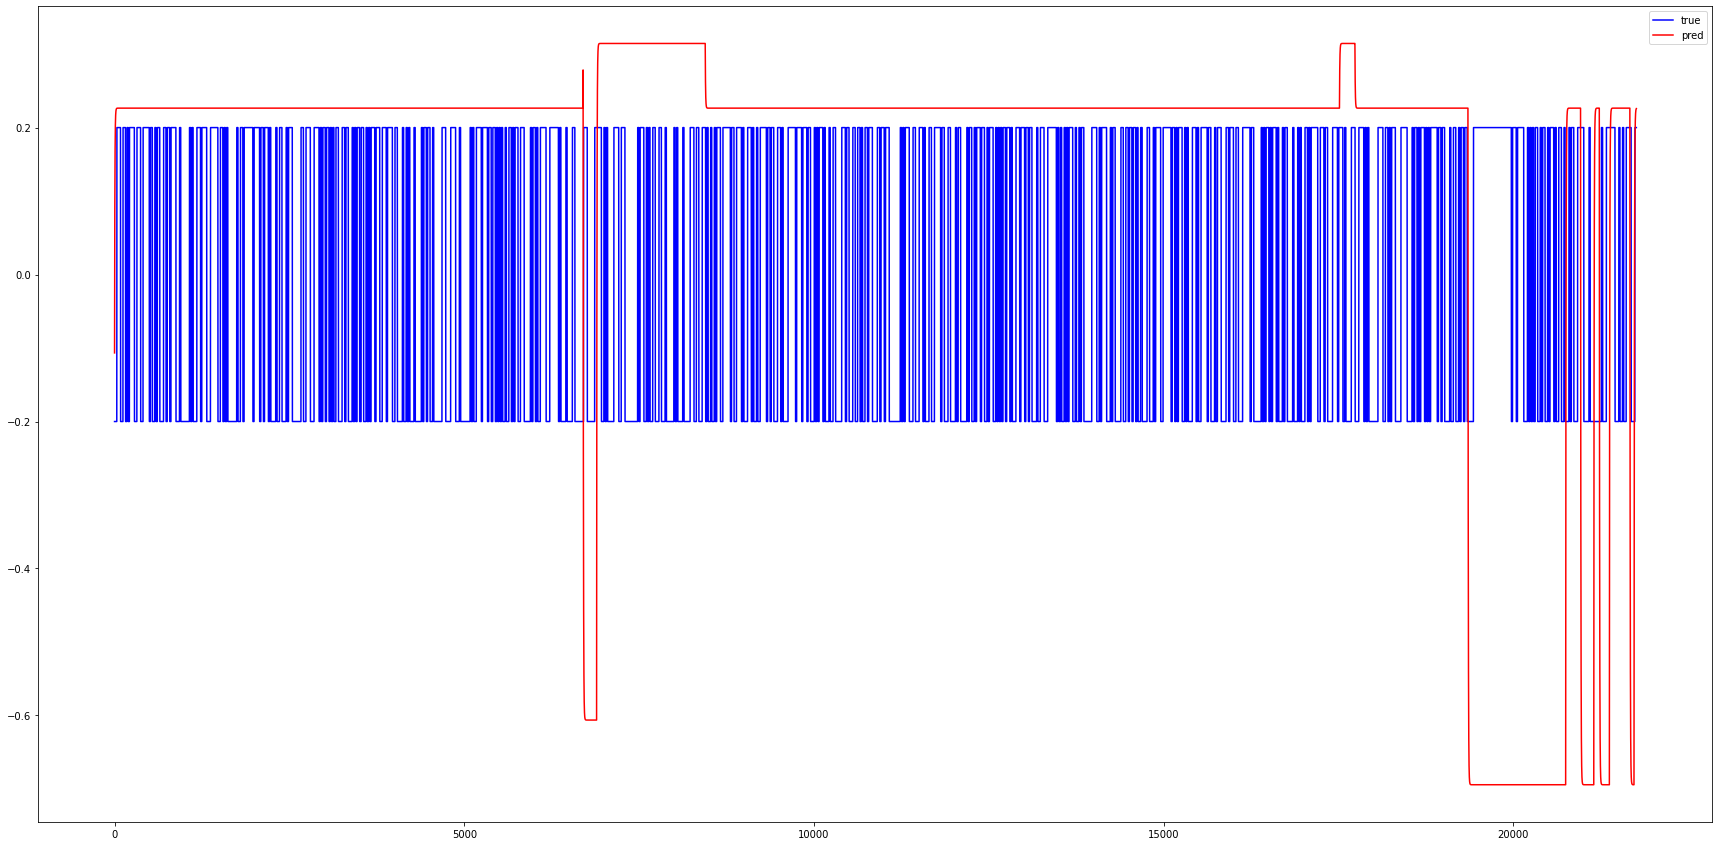

In [ ]:
plt.figure(figsize=(30,15))
plt.plot(y_true, 'b-', label='true')
plt.plot(y_pred, 'r-', label='pred')
plt.legend()

In [ ]:
err

1.0592866414460214

# 5. 정리

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
import math

# data filtering using by user-defined function
eeg=filtering_bandpass(eeg)

eeg['timestamp']=pd.to_datetime(eeg['timestamp'])
train['timestamp']=pd.to_datetime(train['timestamp'])
train=train.rename(columns={' event(1:up':'event'})

eeg_band = eeg.iloc[:,17:]
eeg = eeg.iloc[:,:17]

eeg['event']=0

# deploy target data to eeg data by timestamp (merge train data and eeg data)
for i in range(0,len(train)-1):
  for t in range(0,len(eeg)):
    if train['timestamp'][i]< eeg['timestamp'][t] and (train['timestamp'][i+1]>eeg['timestamp'][t])==True:
       eeg.event[t]=train.event[i]

# drop the columns which doesn't have target data
eeg.drop(eeg.loc[eeg['event']==0].index, inplace=True)

# data split to X / Y (input / target)
train_eeg=eeg.drop(['timestamp'],axis='columns')
train_eeg=train_eeg.iloc[:,:-1].values
train_event=eeg.drop(['timestamp'],axis='columns')
train_event=train_event.iloc[:,-1].values

# data split to train / test
train_length = math.ceil(len(eeg) * 0.75) # train data : 75% of data 
#test_length = len(eeg)-train_length
""" X_train = X[:train_length]
    y_train = X[1:train_length+1]
    X_test = X[train_length:train_length+test_length]
    y_test = X[train_length+1:train_length+test_length+1]
"""

X_train = train_eeg[:train_length]
y_train= train_event[:train_length]
X_test = train_eeg[train_length:]
y_test = train_event[train_length:]

# Simple training
# ESN 모델 생성
# n_readout : 출력층 뉴런수, n_components : reservoir 뉴런수, damping : reservoir 내 뉴런 손실률(뉴런끼리 연결 안될 확률), weight_scaling : 가중치 학습률
my_esn = SimpleESN(n_readout=2, n_components=len(eeg.columns),
                       damping=0.2, weight_scaling=1.25)
'''학습 과정'''
# ESN 모델 사용(통과)
echo_train = my_esn.fit_transform(X_train)
# ESN 거친 후 머신러닝 모델 사용(선형회귀)
# regr = Ridge(alpha=0.05)
regr = LinearRegression()
# regr = SVR()
# 머신러닝 모델 학습
regr.fit(echo_train, y_train)

'''모델 사용 과정'''
# 머신러닝 모델 사용
echo_test = my_esn.transform(X_test)
# 예측
y_true, y_pred = y_test, regr.predict(echo_test)
# 오차
err = mean_squared_error(y_true, y_pred)

In [ ]:
# 시각화
plt.figure(figsize=(15,8))
plt.plot(y_true, 'b-', label='true')
plt.plot(y_pred, 'r-', label='pred')
plt.legend()